# Runge-Kutta methods for differential complementarity problems (DCPs)
Here we test the usage of RadauIIA methods for solving DCPs as they are fully implicit stiffly accurate methods of fairly high order for the number of stages. They also have high stage order, which is the basis for the theory showing the application to DCPs has high order of accuracy when the solution is smooth.

In [1]:
include("rk-dvi.jl")
using .RKDCP
using LaTeXStrings

In [2]:
names(RKDCP)

17-element Vector{Symbol}:
 :DCP
 :RKDCP
 :RKmethod
 :dirkA
 :dirkCR
 :drk_dcp_eqns
 :expEuler
 :heun
 :impEuler
 :nstages
 :radauIIA2
 :radauIIA3
 :rk
 :rk4
 :rk_dcp
 :rk_dcp_eqns
 :trap

In [3]:
?rk_dcp

search: rk_dcp rk_dcp_eqns drk_dcp_eqns



```
rk_dcp(dcp::DCP, rk::RKmethod{T}, t0::T, x0::Vector{T}, z0::Vector{T}, h::T, nsteps::Int; epsilon::T=T(1e-6)) where {T}
```

Returns discrete trajectory for the DCP defined by `dcp` using the Runge-Kutta method `rk`. The initial state is `x0` and initial time `t0`. The error tolerance `epsilon` is used for solving the DCP RK equations. A fixed step size `h` is used. An initial guess `z0` for `z` is passed.


In [4]:
rk = radauIIA2

RKmethod{Float64}("RadauIIA (2-stage)", [0.4166666666666667 -0.08333333333333333; 0.75 0.25], [0.75, 0.25], [0.3333333333333333, 1.0], false)

In [5]:
f(t,y,z) = [-y[1]]
G(y) = [1.0]
dfdy(t,y,z) = [-1.0;;]
dfdz(t,y,z) = [0.0;;]
dG(y) = [0.0;;]
dcp = DCP(f,dfdy,dfdz,G,dG)

DCP(f, dfdy, dfdz, G, dG)

In [6]:
?rk_dcp_eqns

search: rk_dcp_eqns drk_dcp_eqns



```
rk_dcp_eqns(f::Function, G::Function, rk::RKmethod{T}, h::T, t::T, x::Vector{T}, vz_vec::Vector{T}) where {T}
```

Returns  $v_i - x - h\sum_j a_{ij} f(t,v_j,z_j)$ for $j=1,2,\ldots,s$ followed by $\min(z_i, G(v_i))$ for $j = 1,\ldots,s$.

Each $v_i$ is a vector of length $n$ (where dimension of $x$ is $n$), and each $z_i$ is a vector of length $m$ (where dimension of $G(x)$ is $m$). Also $s$ is the number of stages in method `rk`.

The `vz_vec` has length $s(n+m)$ where $v_i$ is in `vz_vec[(i-1)*n+1:i*n]` and $z_i$ is in `vz_vec[n*s+(i-1)*m+1:n*s+i*m]`. The output vector has the same length as `vz_vec` and the corresponding layout.


In [7]:
nstages(rk)

2

In [8]:
vz = [1.0; 1.0; 0.0; 0.0]
rhs = rk_dcp_eqns(dcp, rk, 0.1, 0.0, [1.0], vz)

4-element Vector{Float64}:
 0.03333333333333334
 0.1
 0.0
 0.0

In [9]:
dFvz = drk_dcp_eqns(dcp, rk, 0.1, 0.0, [1.0], vz)

4×4 Matrix{Float64}:
 1.04167  -0.00833333  0.0  0.0
 0.075     1.025       0.0  0.0
 0.0       0.0         1.0  0.0
 0.0       0.0         0.0  1.0

In [10]:
vz = vz - dFvz \ rhs

4-element Vector{Float64}:
 0.9672386895475819
 0.9048361934477379
 0.0
 0.0

In [11]:
xlist,zlist,tlist = rk_dcp(dcp, rk, 0.0, [1.0;], [0.0;], 0.1, 20; epsilon=1e-6)

([[1.0], [0.9048361934477379], [0.8187285369729922], [0.7408152128616778], [0.6703164172539362], [0.6065265553935772], [0.548807179607293], [0.496580599332652], [0.4493240992401531], [0.40656470758079377]  …  [0.3328661282224757], [0.30118932038851154], [0.2725269981674519], [0.24659229163357582], [0.2231256304952792], [0.20189214615797493], [0.18267932101657638], [0.16529486145025632], [0.14956477323112116], [0.13533162008432179]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999  …  1.0999999999999999, 1.2, 1.3, 1.4000000000000001, 1.5000000000000002, 1.6000000000000003, 1.7000000000000004, 1.8000000000000005, 1.9000000000000006, 2.0000000000000004])

In [12]:
using Plots
default(fontfamily="Helvetica",guidefontsize=14,tickfontsize=12,legendfontsize=12)

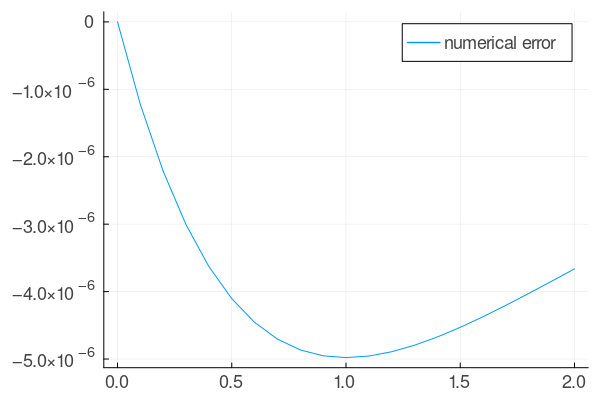

In [13]:
using Plots
plot(tlist,(x->x[1]).(xlist)-exp.(-tlist),label="numerical error")
# plot!(tlist,exp.(-tlist),label="exact solution")

In [14]:
# Now let's consider the problem with G(x) = ||x||_2^2 - 1 and f(x,z) = f(x) + \nabla G(x).z
# dcp = DCP(f,dfdx,dfdz,G,dG)
using LinearAlgebra
f1(x) = [1.0;0.0]
df1dx(x) = zeros(2,2)
dcp2 = DCP(
    (t,x,z) -> f1(x) + 2*z[1]*x, # f
    (t,x,z) -> df1dx(x) + 2*z[1]*I, # dfdx
    (t,x,z) -> 2*x, # dfdz
    x -> [dot(x,x) - 1], # G
    x -> (2*x)' # dG
)

DCP(var"#5#10"(), var"#6#11"(), var"#7#12"(), var"#8#13"(), var"#9#14"())

In [15]:
x0 = [-1.2; 0.5]
z0 = [0.0]
t0 = 0.0
vz0 = [x0; x0; z0; z0]
h = 0.1
@show x0
@show dcp2.G(x0)
@show dcp2.dG(x0)
@show size(dcp2.dG(x0))
rk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
drk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
xlist2,zlist2,tlist2 = rk_dcp(dcp2, rk, t0, x0, z0, 0.1, 40; epsilon=1e-10)

x0 = [-1.2, 0.5]
dcp2.G(x0) = [0.69]
dcp2.dG(x0) = [-2.4 1.0]
size(dcp2.dG(x0)) = (1, 2)


([[-1.2, 0.5], [-1.0999999999999999, 0.5], [-0.9999999999999999, 0.5], [-0.8999999999999999, 0.5], [-0.8484027171296663, 0.5293513290499983], [-0.8178946752101642, 0.5753679694446502], [-0.7819711755428025, 0.6233145920181884], [-0.7399746572636229, 0.6726347497806124], [-0.6912900900813896, 0.7225773393590919], [-0.6354002192863083, 0.7721829843572775]  …  [1.449594406845212, 1.0007536791280682], [1.549594406845212, 1.0007536791280682], [1.6495944068452122, 1.0007536791280682], [1.7495944068452123, 1.0007536791280682], [1.8495944068452124, 1.0007536791280682], [1.9495944068452125, 1.0007536791280682], [2.0495944068452125, 1.0007536791280682], [2.1495944068452126, 1.0007536791280682], [2.2495944068452127, 1.0007536791280682], [2.349594406845213, 1.0007536791280682]], [[0.0], [0.0], [0.0], [0.7203442681563773], [0.40937595077893263], [0.39146880417454893], [0.3705228729292331], [0.34622640848522346], [0.3183154878770463], [0.2866078458908913]  …  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]

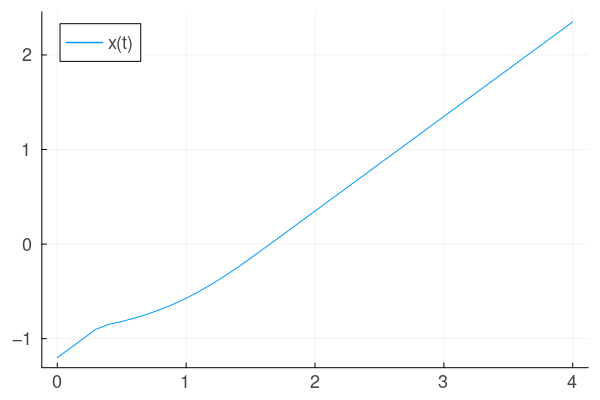

In [16]:
plot(tlist2,(x->x[1]).(xlist2),label="x(t)")

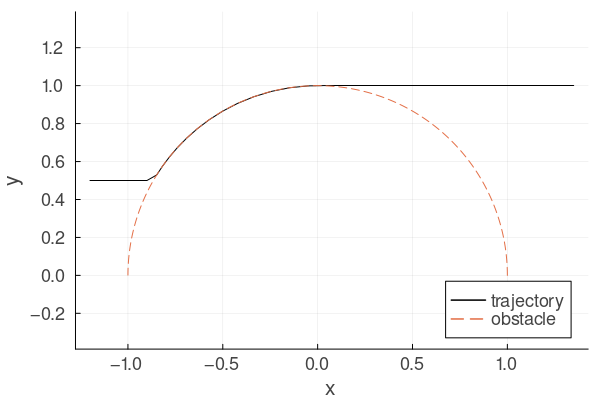

In [17]:
range = 1:31
plot((x->x[1]).(xlist2[range]),(x->x[2]).(xlist2[range]),label="trajectory",color=:black)
plot!([cos(θ) for θ=0:0.01:π],[sin(θ) for θ=0:0.01:π],label="obstacle",linestyle=:dash)
plot!(aspect_ratio=:equal)
plot!(legend=:bottomright, tickfontsize=12,legendfontsize=12,xlabel="x",ylabel="y")
savefig("trajectory-vs-obstacle.svg")
plot!()

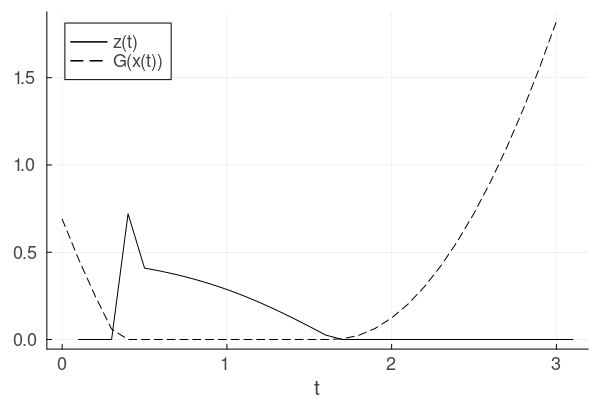

In [18]:
plot(tlist2[range.+1],(z->z[1]).(zlist2[range]),label="z(t)",color=:black)
plot!(tlist2[range],[dcp2.G(xlist2[i])[1] for i in range],label="G(x(t))",color=:black,linestyle=:dash)
plot!(legend=:topleft,xlabel="t")
savefig("z-vs-Gx.svg")
plot!()

In [19]:
size(zlist2)

(40,)

In [20]:
minimum(dcp2.G(xlist2[i]) for i = 1:length(xlist2))

1-element Vector{Float64}:
 -1.1102230246251565e-16

In [21]:
norm([min(dcp2.G(xlist2[i+1])[1],zlist2[i][1]) for i = 1:length(zlist2)],Inf)

4.843236922624783e-12

In [22]:
# Now for the test of accuracy
x0 = [-sqrt(3)/2; 0.5]
z0 = [0.0]
t0 = 0.0
vz0 = [x0; x0; z0; z0]
h = 0.1
# rk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
# drk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
xlist3,zlist3,tlist3 = rk_dcp(dcp2, rk, t0, x0, z0, 0.1, 20; epsilon=1e-10);

In [23]:
[x[1] for x in xlist3]

21-element Vector{Float64}:
 -0.8660254037844386
 -0.8387544902783906
 -0.8065080265605588
 -0.7686241678077922
 -0.7244542597878243
 -0.6734091993347595
 -0.615018950445359
 -0.5490026912239941
 -0.47534352983817024
 -0.3943577534132142
 -0.30674527789481537
 -0.21360691681305105
 -0.116416780635222
 -0.01694514122829631
  0.08305513259718769
  0.1830551325971877
  0.28305513259718773
  0.3830551325971877
  0.4830551325971877
  0.5830551325971877
  0.6830551325971876

In [24]:
τ = 0.5*log((2+sqrt(3))/(2-sqrt(3))) # time to separation

1.3169578969248166

In [25]:
C1 = (2-sqrt(3))/(2+sqrt(3))
exactx(t) = (t <= τ) ? (C1*exp(2t)-1) / (C1*exp(2t)+1) : t - τ

exactx (generic function with 1 method)

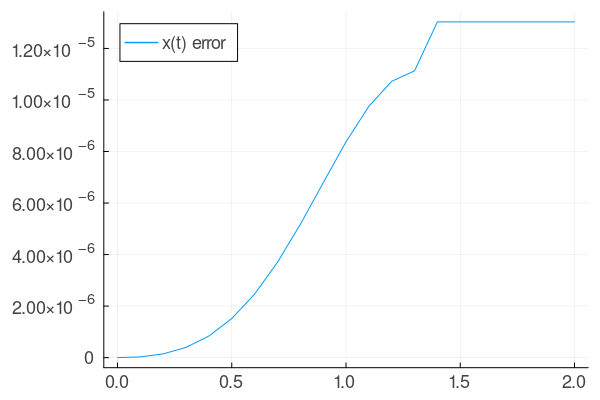

In [26]:
plot(tlist3,abs.([x[1] for x in xlist3]-exactx.(tlist3)),label="x(t) error")

In [27]:
maxerr = maximum(abs.([x[1] for x in xlist3]-exactx.(tlist3)))

1.30295220041321e-5

In [28]:
a = 0.0; b = 2.0
nlist = sort([10 .^(1:4); 2 .*(10 .^(0:3)); 4 .*(10 .^(0:3))])
hlist = (b-a) ./ nlist

12-element Vector{Float64}:
 1.0
 0.5
 0.2
 0.1
 0.05
 0.02
 0.01
 0.005
 0.002
 0.001
 0.0005
 0.0002

In [29]:
maxerr_r2A2 = zeros(length(nlist))
for i = 1:length(nlist)
    x0 = [-sqrt(3)/2; 0.5]
    z0 = [0.0]
    t0 = 0.0
    vz0 = [x0; x0; z0; z0]
    h = hlist[i]
    n = nlist[i]
    # rk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
    # drk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
    xs,zs,ts = rk_dcp(dcp2, rk, t0, x0, z0, h, n; epsilon=1e-10);
    maxerr_r2A2[i] = maximum(abs.([x[1] for x in xs]-exactx.(ts)))
    println("Done for n = $(nlist[i])")
end

Done for n = 2
Done for n = 4
Done for n = 10
Done for n = 20
Done for n = 40
Done for n = 100
Done for n = 200
Done for n = 400
Done for n = 1000
Done for n = 2000
Done for n = 4000
Done for n = 10000


In [30]:
maxerr_r2A2

12-element Vector{Float64}:
 0.023547722910455704
 0.0014548544608026237
 0.00011709699531159412
 1.30295220041321e-5
 2.9456772419333976e-6
 8.9446946731353e-8
 1.1196319340406324e-8
 2.919519626054523e-9
 1.6434364980000282e-10
 1.1271267231181825e-11
 1.4915003910750957e-12
 2.033303538560849e-13

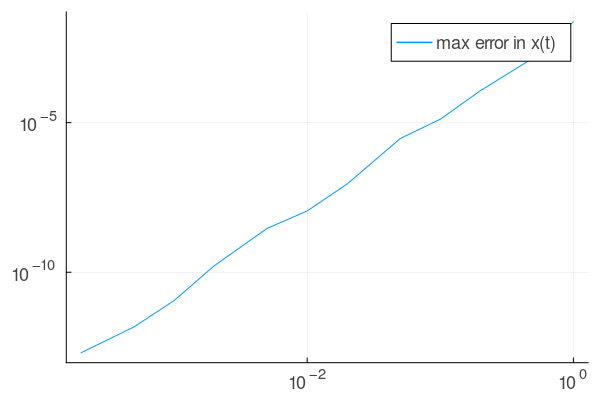

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


In [31]:
plot(hlist,maxerr_r2A2,scale=:log10,label="max error in x(t)")

In [32]:
slope = (log(maxerr_r2A2[12])-log(maxerr_r2A2[1]))/(log(hlist[12])-log(hlist[1]))

2.9910344467077334

In [33]:
# Using Euler's method (1-stage RadauIIA method)
maxerr_r2A1 = zeros(length(nlist))
for i = 1:length(nlist)
    x0 = [-sqrt(3)/2; 0.5]
    z0 = [0.0]
    t0 = 0.0
    vz0 = [x0; x0; z0; z0]
    h = hlist[i]
    n = nlist[i]
    # rk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
    # drk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
    xs,zs,ts = rk_dcp(dcp2, impEuler, t0, x0, z0, h, n; epsilon=1e-10);
    maxerr_r2A1[i] = maximum(abs.([x[1] for x in xs]-exactx.(ts)))
    println("Done for n = $(nlist[i])")
end

Done for n = 2
Done for n = 4
Done for n = 10
Done for n = 20
Done for n = 40
Done for n = 100
Done for n = 200
Done for n = 400
Done for n = 1000
Done for n = 2000
Done for n = 4000
Done for n = 10000


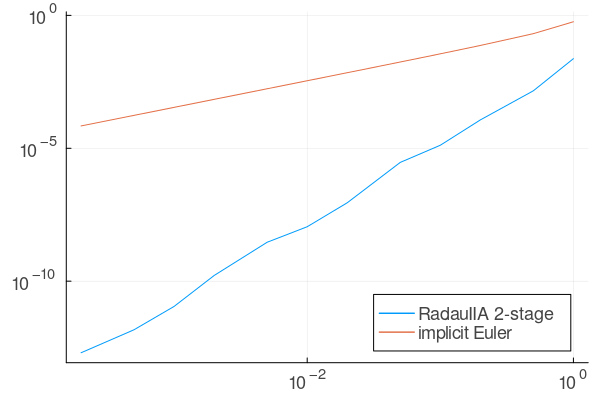

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


In [34]:
plot(hlist,maxerr_r2A2,scale=:log10,label="RadauIIA 2-stage")
plot!(hlist,maxerr_r2A1,scale=:log10,label="implicit Euler",legend=:bottomright)

In [35]:
# Using Euler's method (1-stage RadauIIA method)
maxerr_r2A3 = zeros(length(nlist))
for i = 1:length(nlist)
    x0 = [-sqrt(3)/2; 0.5]
    z0 = [0.0]
    t0 = 0.0
    vz0 = [x0; x0; z0; z0]
    h = hlist[i]
    n = nlist[i]
    # rk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
    # drk_dcp_eqns(dcp2, rk, h, t0, x0, vz0)
    xs,zs,ts = rk_dcp(dcp2, radauIIA3, t0, x0, z0, h, n; epsilon=1e-10);
    maxerr_r2A3[i] = maximum(abs.([x[1] for x in xs]-exactx.(ts)))
    println("Done for n = $(nlist[i])")
end

Done for n = 2
Done for n = 4
Done for n = 10
Done for n = 20
Done for n = 40
Done for n = 100
Done for n = 200
Done for n = 400
Done for n = 1000
Done for n = 2000
Done for n = 4000
Done for n = 10000


In [36]:
plot(hlist,maxerr_r2A1,scale=:log10,label="implicit Euler")
plot!(hlist,maxerr_r2A2,scale=:log10,label="RadauIIA 2-stage")
plot!(hlist,maxerr_r2A3,scale=:log10,label="RadauIIA 3-stage")
savefig("rk-dcp-maxerr-ext.svg")

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


"C:\\Users\\dstew\\OneDrive - University of Iowa\\Documents\\papers\\davinci\\runge-kutta\\codes\\rk-dcp-maxerr-ext.svg"

In [37]:
a = 0.0; b = 1.2
nlist = sort([10 .^(1:4); 2 .*(10 .^(0:3)); 4 .*(10 .^(0:3))])
hlist = (b-a) ./ nlist

rklist = [impEuler, radauIIA2, radauIIA3]
maxerrlist = []
for rk in rklist
    maxerr = zeros(length(nlist))
    for i = 1:length(nlist)
        x0 = [-sqrt(3)/2; 0.5]
        z0 = [0.0]
        t0 = 0.0
        vz0 = [x0; x0; z0; z0]
        h = hlist[i]
        n = nlist[i]
        xs,zs,ts = rk_dcp(dcp2, rk, t0, x0, z0, h, n; epsilon=1e-10);
        maxerr[i] = maximum(abs.([x[1] for x in xs]-exactx.(ts)))
        println("Done for n = $(nlist[i]) and method $(rk.name)")
        
    end
    println("maxerr = $maxerr")
    push!(maxerrlist,copy(maxerr))
end

Done for n = 2 and method implicit Euler
Done for n = 4 and method implicit Euler
Done for n = 10 and method implicit Euler
Done for n = 20 and method implicit Euler
Done for n = 40 and method implicit Euler
Done for n = 100 and method implicit Euler
Done for n = 200 and method implicit Euler
Done for n = 400 and method implicit Euler
Done for n = 1000 and method implicit Euler
Done for n = 2000 and method implicit Euler
Done for n = 4000 and method implicit Euler
Done for n = 10000 and method implicit Euler
maxerr = [0.2624333242850919, 0.11477413321453507, 0.04260291798886999, 0.02079553499176863, 0.010275248993968505, 0.004081189292414841, 0.0020358169083237593, 0.001016717805645398, 0.00040640184992864203, 0.00020315341980009505, 0.00010156483745414613, 4.062308613411725e-5]
Done for n = 2 and method RadauIIA (2-stage)
Done for n = 4 and method RadauIIA (2-stage)
Done for n = 10 and method RadauIIA (2-stage)
Done for n = 20 and method RadauIIA (2-stage)
Done for n = 40 and method R

In [38]:
for i in 1:length(rklist)
    println("Max error for method $(rklist[i].name) is ",maxerrlist[i])
end

Max error for method implicit Euler is [0.2624333242850919, 0.11477413321453507, 0.04260291798886999, 0.02079553499176863, 0.010275248993968505, 0.004081189292414841, 0.0020358169083237593, 0.001016717805645398, 0.00040640184992864203, 0.00020315341980009505, 0.00010156483745414613, 4.062308613411725e-5]
Max error for method RadauIIA (2-stage) is [0.002413451764769023, 0.0002899060641381318, 1.8519149403845026e-5, 2.319926256849625e-6, 2.9043656192551115e-7, 1.860758215566083e-8, 2.326816392339559e-9, 2.9091402897751806e-10, 1.8621174047162015e-11, 2.3210877664325835e-12, 3.5023373090581345e-13, 1.268984917146554e-13]
Max error for method RadauIIA (3-stage) is [3.266025490457347e-5, 9.373753425412357e-7, 9.18718941200769e-9, 2.836767071245916e-10, 8.803013873404097e-12, 9.00390872971002e-14, 3.400058012914542e-15, 6.453171330633722e-15, 3.8413716652030416e-14, 3.058664432842306e-14, 5.920264278813647e-14, 1.1171619185290638e-13]


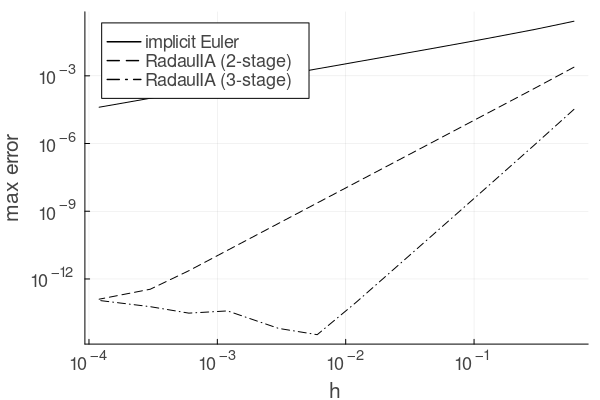

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


"C:\\Users\\dstew\\OneDrive - University of Iowa\\Documents\\papers\\davinci\\runge-kutta\\codes\\rk-dcp-maxerr.svg"

In [39]:
style = [:solid, :dash, :dashdot]
plt = plot()
for i in 1:length(rklist)
    plot!(plt,hlist,maxerrlist[i],scale=:log10,label=rklist[i].name,
    yaxis=10.0.^(-15:3:0),xticks=10.0.^(-4:0),
    xlabel="h",ylabel="max error",color=:black,linestyle=style[i])
end
plot!(plt,legend=:topleft)
display(plt)
savefig(plt,"rk-dcp-maxerr.svg")

In [40]:
slopes = zeros(length(rklist))
for i in 1:length(rklist)
    slopes[i] = (log(maxerrlist[i][6])-log(maxerrlist[i][1]))/(log(hlist[6])-log(hlist[1]))
end
slopes

3-element Vector{Float64}:
 1.0643108698716053
 3.0094402286286335
 5.038104536337274

In [41]:
hlist[1],hlist[6]

(0.6, 0.012)

In [42]:
rklist[2].A

2×2 Matrix{Float64}:
 0.416667  -0.0833333
 0.75       0.25

In [43]:
# Now compute max error over longer interval including leaving obstacle
a = 0.0; b = 2.0
nlist = sort([10 .^(1:4); 2 .*(10 .^(0:3)); 4 .*(10 .^(0:3))])
hlist = (b-a) ./ nlist

rklist = [impEuler, radauIIA2, radauIIA3]
maxerrlist1 = []
for rk in rklist
    maxerr = zeros(length(nlist))
    for i = 1:length(nlist)
        x0 = [-sqrt(3)/2; 0.5]
        z0 = [0.0]
        t0 = 0.0
        vz0 = [x0; x0; z0; z0]
        h = hlist[i]
        n = nlist[i]
        xs,zs,ts = rk_dcp(dcp2, rk, t0, x0, z0, h, n; epsilon=1e-10);
        maxerr[i] = maximum(abs.([x[1] for x in xs]-exactx.(ts)))
        println("Done for n = $(nlist[i]) and method $(rk.name)")
        
    end
    println("maxerr = $maxerr")
    push!(maxerrlist1,copy(maxerr))
end

Done for n = 2 and method implicit Euler
Done for n = 4 and method implicit Euler
Done for n = 10 and method implicit Euler
Done for n = 20 and method implicit Euler
Done for n = 40 and method implicit Euler
Done for n = 100 and method implicit Euler
Done for n = 200 and method implicit Euler
Done for n = 400 and method implicit Euler
Done for n = 1000 and method implicit Euler
Done for n = 2000 and method implicit Euler
Done for n = 4000 and method implicit Euler
Done for n = 10000 and method implicit Euler
maxerr = [0.5757769420273375, 0.20526717405966144, 0.073898030383305, 0.03580669492529963, 0.017608906223278452, 0.006975231151036683, 0.003476710072302769, 0.001735616671930007, 0.0006935864061076158, 0.00034668335640630765, 0.000173314232822408, 6.93191079589317e-5]
Done for n = 2 and method RadauIIA (2-stage)
Done for n = 4 and method RadauIIA (2-stage)
Done for n = 10 and method RadauIIA (2-stage)
Done for n = 20 and method RadauIIA (2-stage)
Done for n = 40 and method RadauIIA

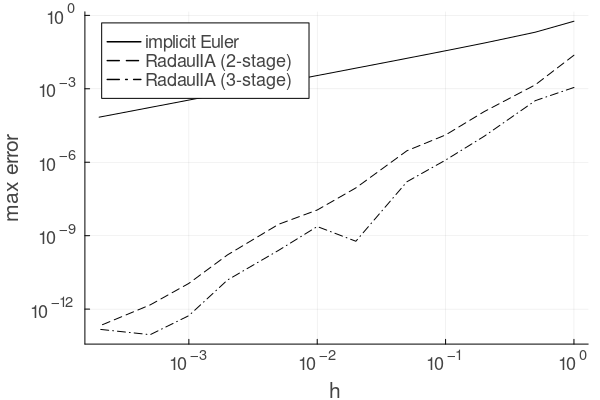

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\dstew\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


"C:\\Users\\dstew\\OneDrive - University of Iowa\\Documents\\papers\\davinci\\runge-kutta\\codes\\rk-dcp-maxerr1.svg"

In [44]:
style = [:solid, :dash, :dashdot]
plt = plot()
for i in 1:length(rklist)
    plot!(plt,hlist,maxerrlist1[i],scale=:log10,label=rklist[i].name,
    yaxis=10.0.^(-15:3:0),xticks=10.0.^(-4:0),
    xlabel="h",ylabel="max error",color=:black,linestyle=style[i])
end
plot!(plt,legend=:topleft)
display(plt)
savefig(plt,"rk-dcp-maxerr1.svg")